In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

BASE_DIR = Path("..")
INTERMEDIATE_DIR = BASE_DIR / "data" / "intermediate"

print("=" * 80)
print("COMPREHENSIVE INTERMEDIATE DATASET ANALYSIS")
print("=" * 80)

COMPREHENSIVE INTERMEDIATE DATASET ANALYSIS


In [2]:
print("\nLoading intermediate parquet files...")

# Updated pattern: sample_XXXXX.parquet instead of data_rank*.parquet
parquet_files = sorted(INTERMEDIATE_DIR.glob("sample_*.parquet"))
print(f"   Found {len(parquet_files)} files")

dfs = []
for pf in parquet_files[:10]:  # Show first 10 for brevity
    df = pd.read_parquet(pf)
    dfs.append(df)
    print(f"   {pf.name}: {len(df)} rows")

# Load all files
all_files = list(INTERMEDIATE_DIR.glob("sample_*.parquet"))
dfs = [pd.read_parquet(f) for f in all_files]

if len(dfs) > 10:
    print(f"   ... and {len(dfs) - 10} more files")

df_full = pd.concat(dfs, ignore_index=True)

print(f"\nTotal loaded: {len(df_full):,} rows")
print(f"Columns: {list(df_full.columns)}")
print(f"Memory usage: {df_full.memory_usage(deep=True).sum() / (1024**2):.1f} MB")

print("\nDataset Info:")
print(f"   Unique samples: {df_full['sample_id'].nunique()}")
print(f"   Unique params: {df_full['param_id'].nunique()}")
print(f"   Image shape (first): {df_full['image_shape'].iloc[0]}")


Loading intermediate parquet files...
   Found 100 files
   sample_05000.parquet: 100 rows
   sample_05001.parquet: 100 rows
   sample_05002.parquet: 100 rows
   sample_05003.parquet: 100 rows
   sample_05004.parquet: 100 rows
   sample_05005.parquet: 100 rows
   sample_05006.parquet: 100 rows
   sample_05007.parquet: 100 rows
   sample_05008.parquet: 100 rows
   sample_05009.parquet: 100 rows
   ... and 90 more files

Total loaded: 10,000 rows
Columns: ['sample_id', 'param_id', 'image_compressed', 'image_shape', 'input_params', 'microstructure_outputs', 'performance_outputs']
Memory usage: 2025.6 MB

Dataset Info:
   Unique samples: 100
   Unique params: 100
   Image shape (first): [128 128 128]


In [3]:
# Feature definitions - UPDATED to match actual outputs
INPUT_FEATURES = [
    "input_SEI kinetic rate constant [m.s-1]",
    "input_Electrolyte diffusivity [m2.s-1]",
    "input_Initial concentration in electrolyte [mol.m-3]",
    "input_Separator porosity",
    "input_Positive particle radius [m]",
    "input_Negative particle radius [m]",
    "input_Positive electrode thickness [m]",
    "input_Negative electrode thickness [m]",
    "input_Outer SEI solvent diffusivity [m2.s-1]",
    "input_Dead lithium decay constant [s-1]",
    "input_Lithium plating kinetic rate constant [m.s-1]",
    "input_Negative electrode LAM constant proportional term [s-1]",
    "input_Negative electrode cracking rate",
    "input_Outer SEI partial molar volume [m3.mol-1]",
    "input_SEI growth activation energy [J.mol-1]",
]

MICROSTRUCTURE_FEATURES = [
    "D_eff",
    "porosity_measured",
    "tau_factor",
    "bruggeman_derived",
]

# UPDATED: These are the actual computed performance features
PERFORMANCE_FEATURES = [
    "projected_cycle_life",
    "capacity_fade_rate",
    "internal_resistance",
    "nominal_capacity",
    "energy_density",
]

# Expand nested arrays into flat columns
input_arrays = np.array(df_full["input_params"].tolist())
df_inputs = pd.DataFrame(input_arrays, columns=INPUT_FEATURES)

micro_arrays = np.array(df_full["microstructure_outputs"].tolist())
df_micro = pd.DataFrame(micro_arrays, columns=MICROSTRUCTURE_FEATURES)

perf_arrays = np.array(df_full["performance_outputs"].tolist())
df_perf = pd.DataFrame(perf_arrays, columns=PERFORMANCE_FEATURES)

df_expanded = pd.concat(
    [
        df_full[["sample_id", "param_id"]].reset_index(drop=True),
        df_inputs,
        df_micro,
        df_perf,
    ],
    axis=1,
)

print(f"\n{'='*80}")
print(f"EXPANDED DATASET")
print(f"{'='*80}")
print(f"   Shape: {df_expanded.shape}")
print(f"   Total columns: {len(df_expanded.columns)}")
print(f"   Input features: {len(INPUT_FEATURES)}")
print(f"   Microstructure features: {len(MICROSTRUCTURE_FEATURES)}")
print(f"   Performance features: {len(PERFORMANCE_FEATURES)}")
print(f"{'='*80}\n")


EXPANDED DATASET
   Shape: (10000, 26)
   Total columns: 26
   Input features: 15
   Microstructure features: 4
   Performance features: 5



In [4]:
input_stats = df_inputs.describe().T
input_stats["missing"] = df_inputs.isnull().sum()
input_stats["missing_pct"] = (input_stats["missing"] / len(df_inputs) * 100).round(2)

cols = [
    "count",
    "mean",
    "std",
    "min",
    "25%",
    "50%",
    "75%",
    "max",
    "missing",
    "missing_pct",
]
input_stats = input_stats[cols]

print(input_stats.to_string())

missing_features = input_stats[input_stats["missing"] > 0]
constant_features = input_stats[input_stats["std"] == 0]

print("\nMissing features:")
print(missing_features[["missing", "missing_pct"]] if len(missing_features) else "None")

print("\nConstant features:")
print(constant_features[["mean"]] if len(constant_features) else "None")

                                                                 count          mean           std           min           25%           50%           75%           max  missing  missing_pct
input_SEI kinetic rate constant [m.s-1]                        10000.0  4.823800e-14  3.974999e-14  1.000000e-14  1.000000e-14  2.970000e-14  1.000000e-13  1.000000e-13        0          0.0
input_Electrolyte diffusivity [m2.s-1]                         10000.0  3.014400e-10  5.824488e-11  2.000000e-10  2.520000e-10  3.045000e-10  3.525000e-10  3.980000e-10        0          0.0
input_Initial concentration in electrolyte [mol.m-3]           10000.0  1.000000e+03  0.000000e+00  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03        0          0.0
input_Separator porosity                                       10000.0  5.849530e-01  2.804550e-02  5.380924e-01  5.602955e-01  5.835018e-01  6.079240e-01  6.363797e-01        0          0.0
input_Positive particle radius [m]           

In [5]:
micro_stats = df_micro.describe().T
micro_stats["missing"] = df_micro.isnull().sum()
micro_stats["missing_pct"] = (micro_stats["missing"] / len(df_micro) * 100).round(2)
micro_stats = micro_stats[cols]

print(micro_stats.to_string())

                     count         mean           std            min       25%       50%       75%        max  missing  missing_pct
D_eff              10000.0     0.169028      0.089877      -0.000001  0.096046  0.163874  0.243770   0.440176        0          0.0
porosity_measured  10000.0     0.481076      0.074868       0.316413  0.422592  0.476487  0.539763   0.652044        0          0.0
tau_factor         10000.0 -3130.721328  31189.471968 -313446.531250  2.331789  2.945959  4.379449  15.862245        0          0.0
bruggeman_derived  10000.0     1.595999      0.025055       1.400000  1.600000  1.600000  1.600000   1.600000        0          0.0


In [6]:
print(f"\n{'='*80}")
print(f"PERFORMANCE FEATURES STATISTICS")
print(f"{'='*80}\n")

perf_stats = df_perf.describe().T
perf_stats["missing"] = df_perf.isnull().sum()
perf_stats["missing_pct"] = (perf_stats["missing"] / len(df_perf) * 100).round(2)

cols = [
    "count",
    "mean",
    "std",
    "min",
    "25%",
    "50%",
    "75%",
    "max",
    "missing",
    "missing_pct",
]
perf_stats = perf_stats[cols]

print(perf_stats.to_string())

# Individual feature summaries
print(f"\n{'-'*80}")
print("PERFORMANCE FEATURE SUMMARIES")
print(f"{'-'*80}")

for feat in PERFORMANCE_FEATURES:
    data = df_perf[feat].dropna()
    if len(data) > 0:
        print(f"\n{feat}:")
        print(f"   Count: {len(data):,}")
        print(f"   Mean: {data.mean():.4f}")
        print(f"   Std: {data.std():.4f}")
        print(f"   Min: {data.min():.4f}")
        print(f"   Max: {data.max():.4f}")
        print(
            f"   Missing: {df_perf[feat].isnull().sum():,} ({df_perf[feat].isnull().sum()/len(df_perf)*100:.2f}%)"
        )
    else:
        print(f"\n{feat}: No data available")


PERFORMANCE FEATURES STATISTICS

                       count       mean        std        min        25%        50%        75%        max  missing  missing_pct
projected_cycle_life  9839.0  42.408781  19.606471  13.000000  24.000000  36.000000  62.000000  78.000000      161         1.61
capacity_fade_rate    9839.0   0.027544   0.012962   0.007221   0.016187   0.025156   0.036749   0.065011      161         1.61
internal_resistance   9839.0   0.101353   0.004493   0.079754   0.097988   0.101469   0.104561   0.111489      161         1.61
nominal_capacity      9839.0   5.429408   0.929852   2.916068   4.709435   5.450128   6.135432   8.028255      161         1.61
energy_density        9839.0   3.884272   0.032036   3.782936   3.863400   3.881627   3.901173   4.121284      161         1.61

--------------------------------------------------------------------------------
PERFORMANCE FEATURE SUMMARIES
--------------------------------------------------------------------------------

proj

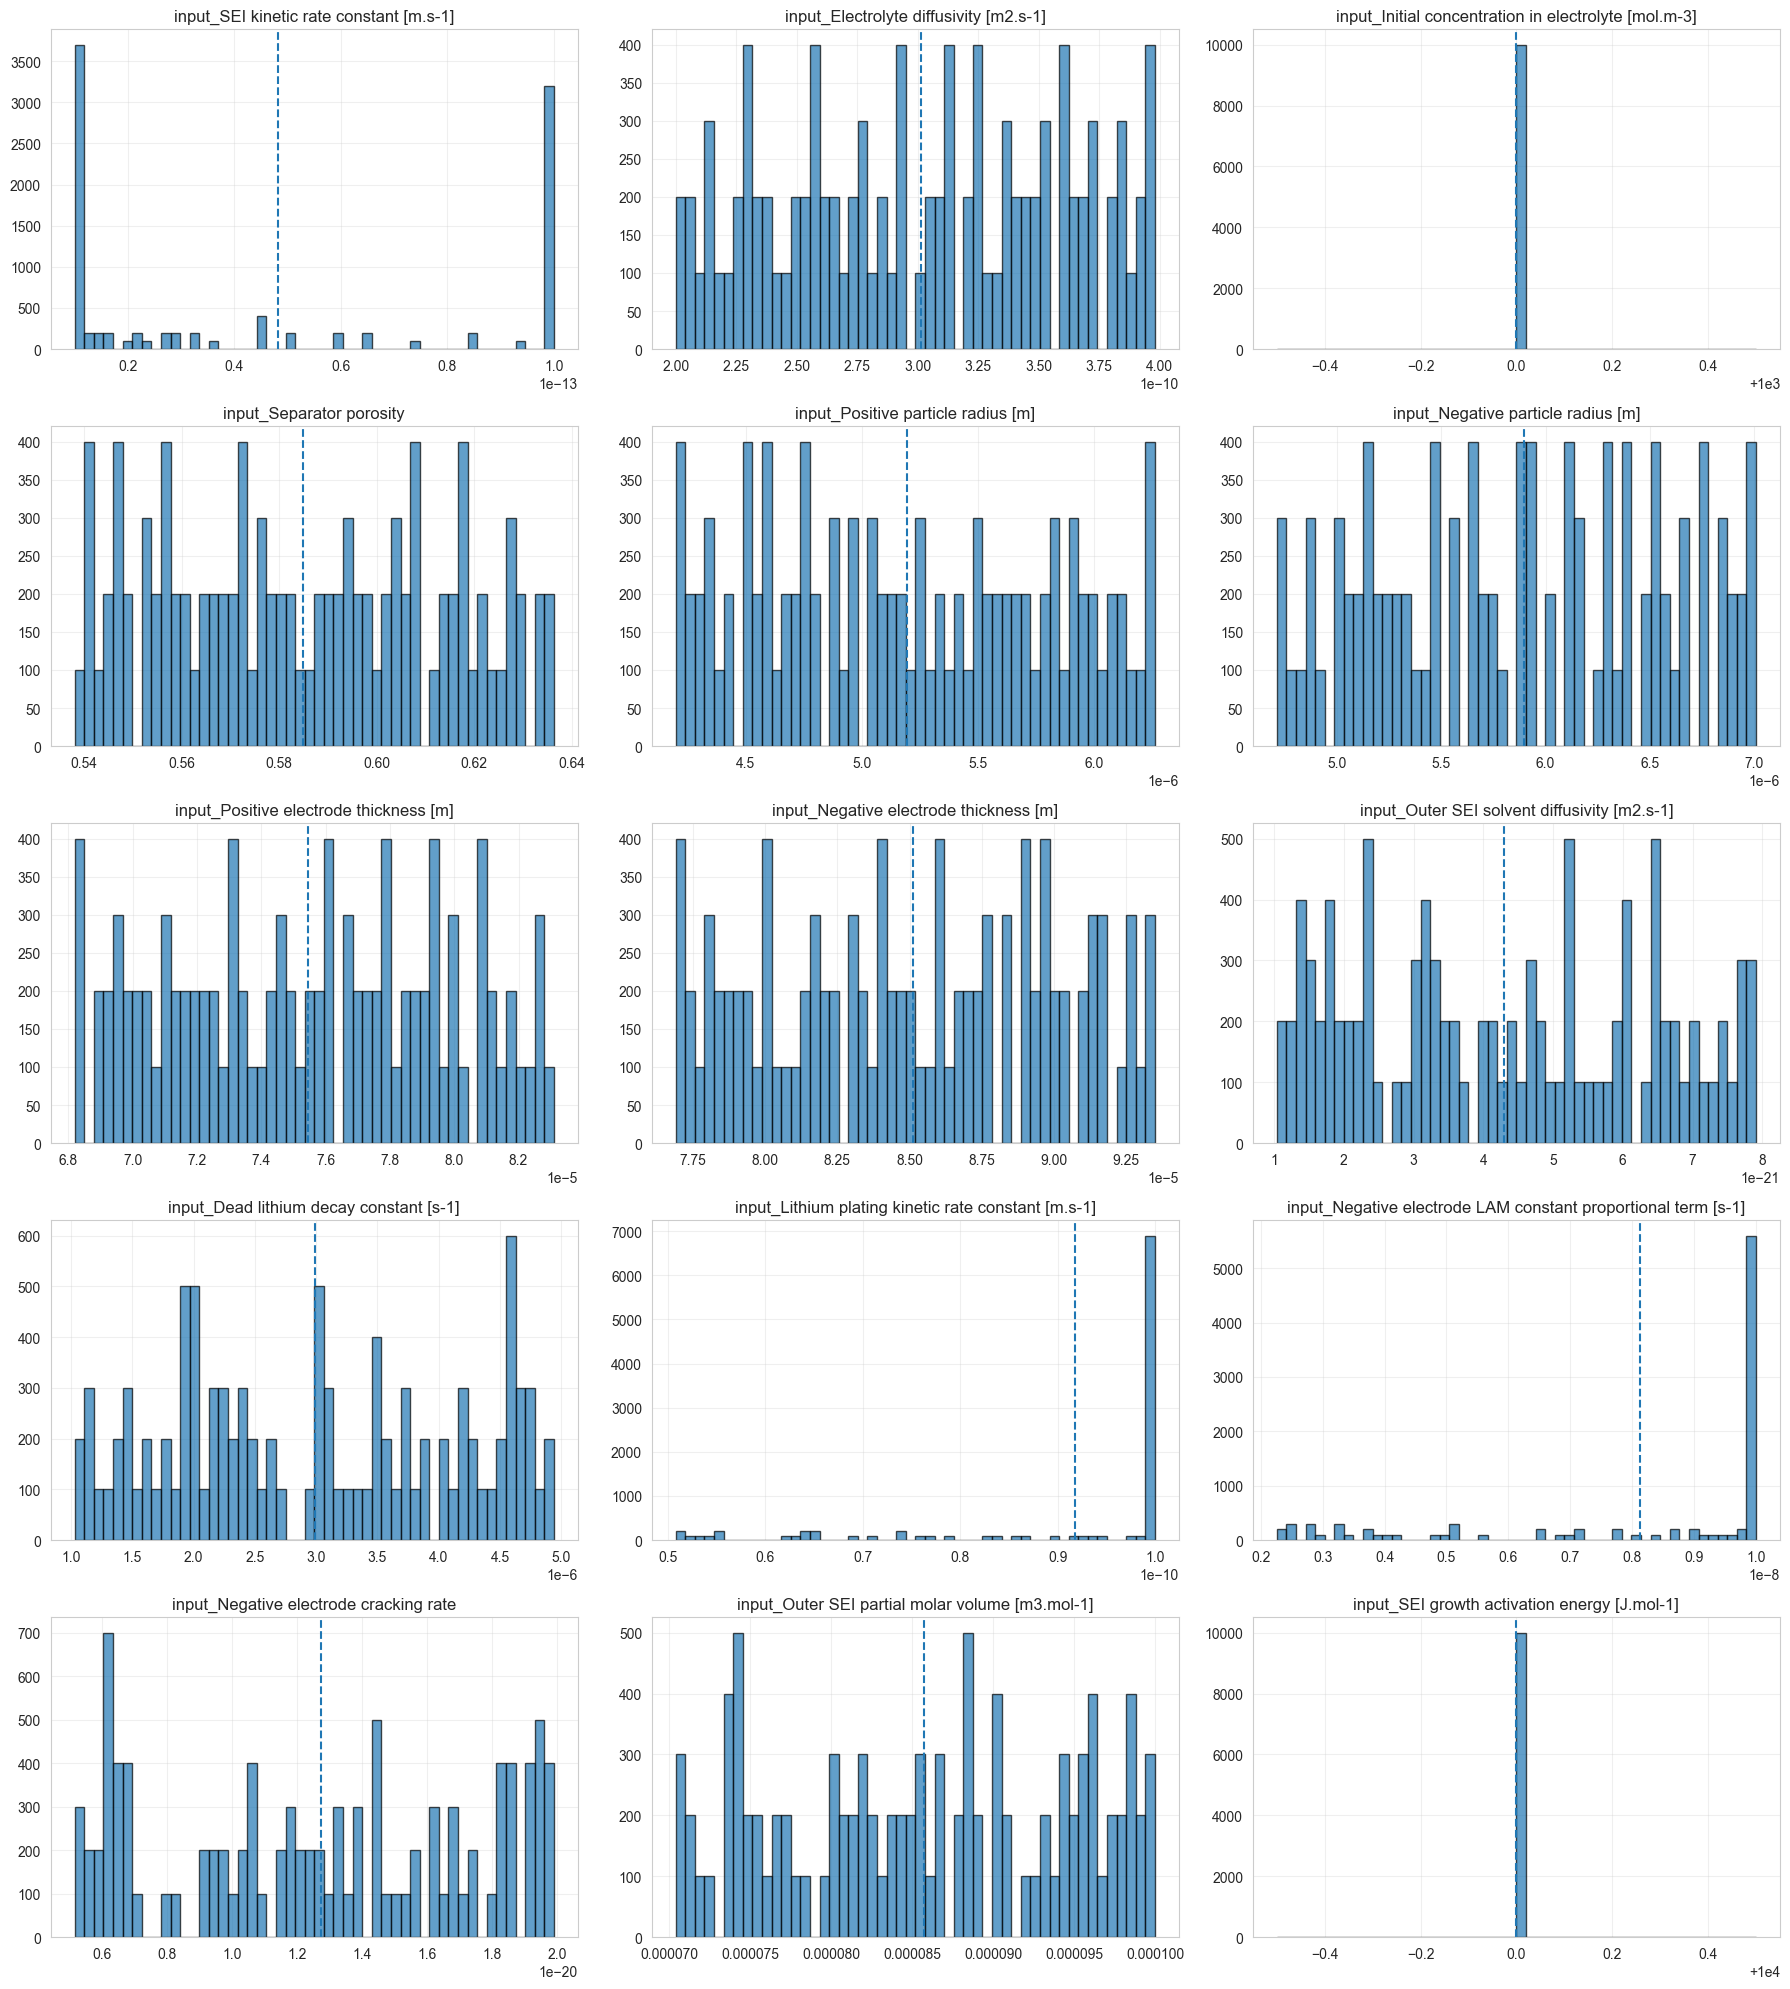

In [7]:
n_features = len(INPUT_FEATURES)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for idx, feat in enumerate(INPUT_FEATURES):
    data = df_inputs[feat].dropna()
    ax = axes[idx]
    ax.hist(data, bins=50, alpha=0.7, edgecolor="black")
    ax.axvline(data.mean(), linestyle="--")
    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

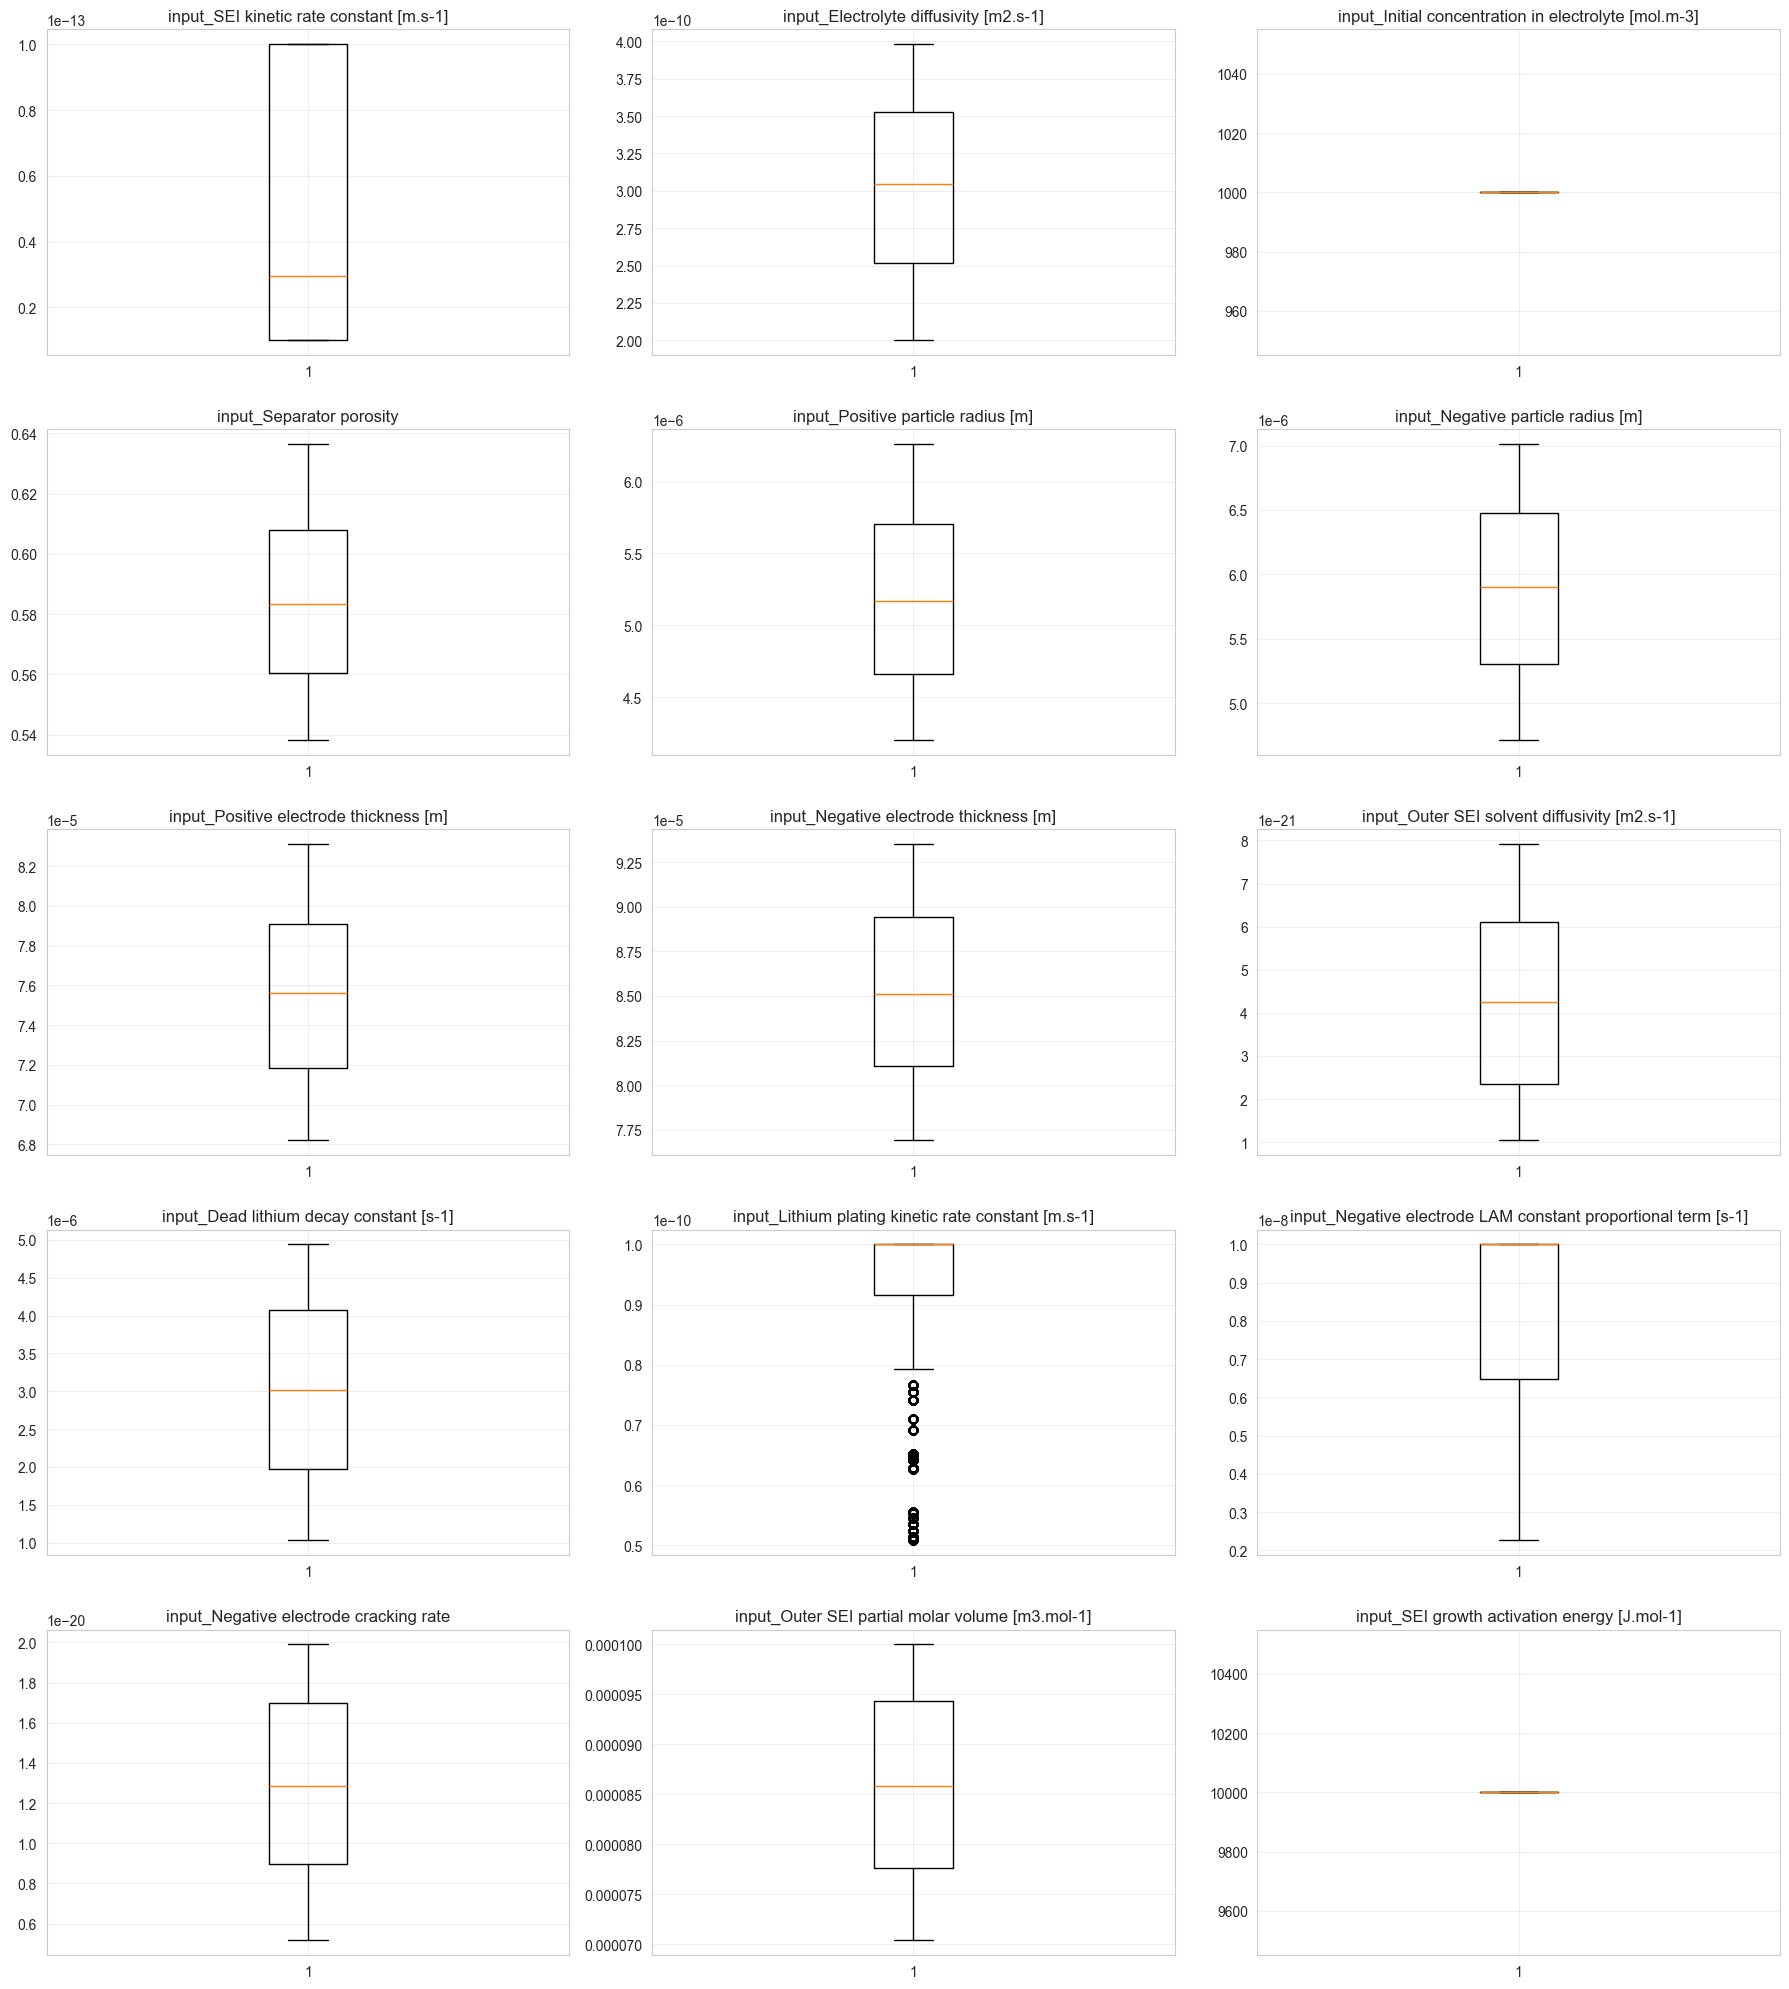

In [8]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for idx, feat in enumerate(INPUT_FEATURES):
    data = df_inputs[feat].dropna()
    ax = axes[idx]
    ax.boxplot(data, vert=True)
    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

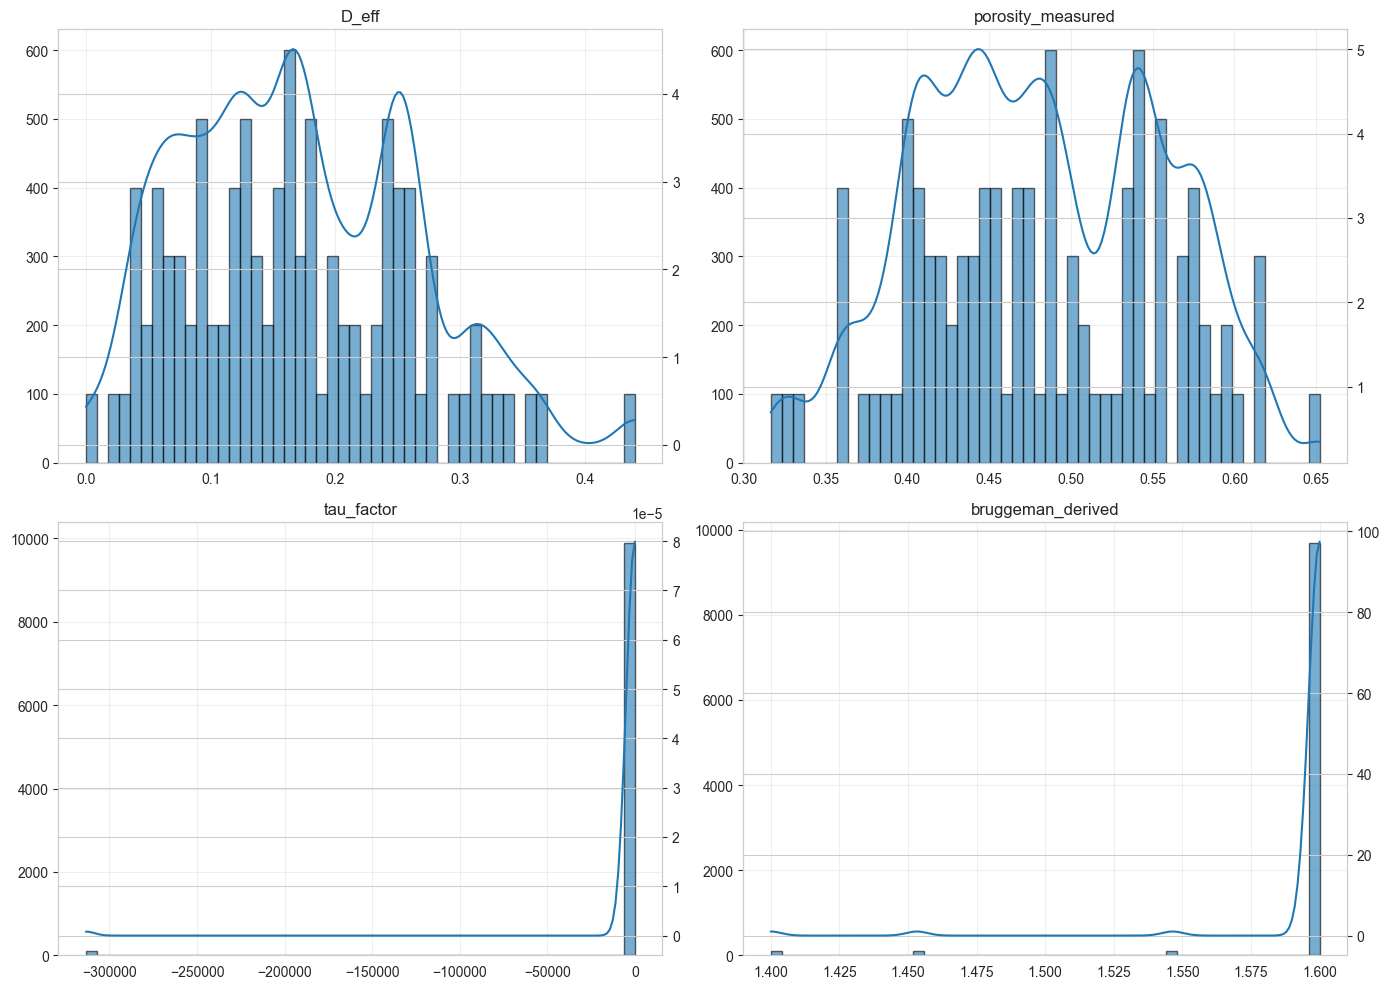

In [9]:
from scipy import stats

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feat in enumerate(MICROSTRUCTURE_FEATURES):
    data = df_micro[feat].dropna()
    ax = axes[idx]
    ax.hist(data, bins=50, alpha=0.6, edgecolor="black")

    density = stats.gaussian_kde(data)
    xs = np.linspace(data.min(), data.max(), 200)
    ax2 = ax.twinx()
    ax2.plot(xs, density(xs))

    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

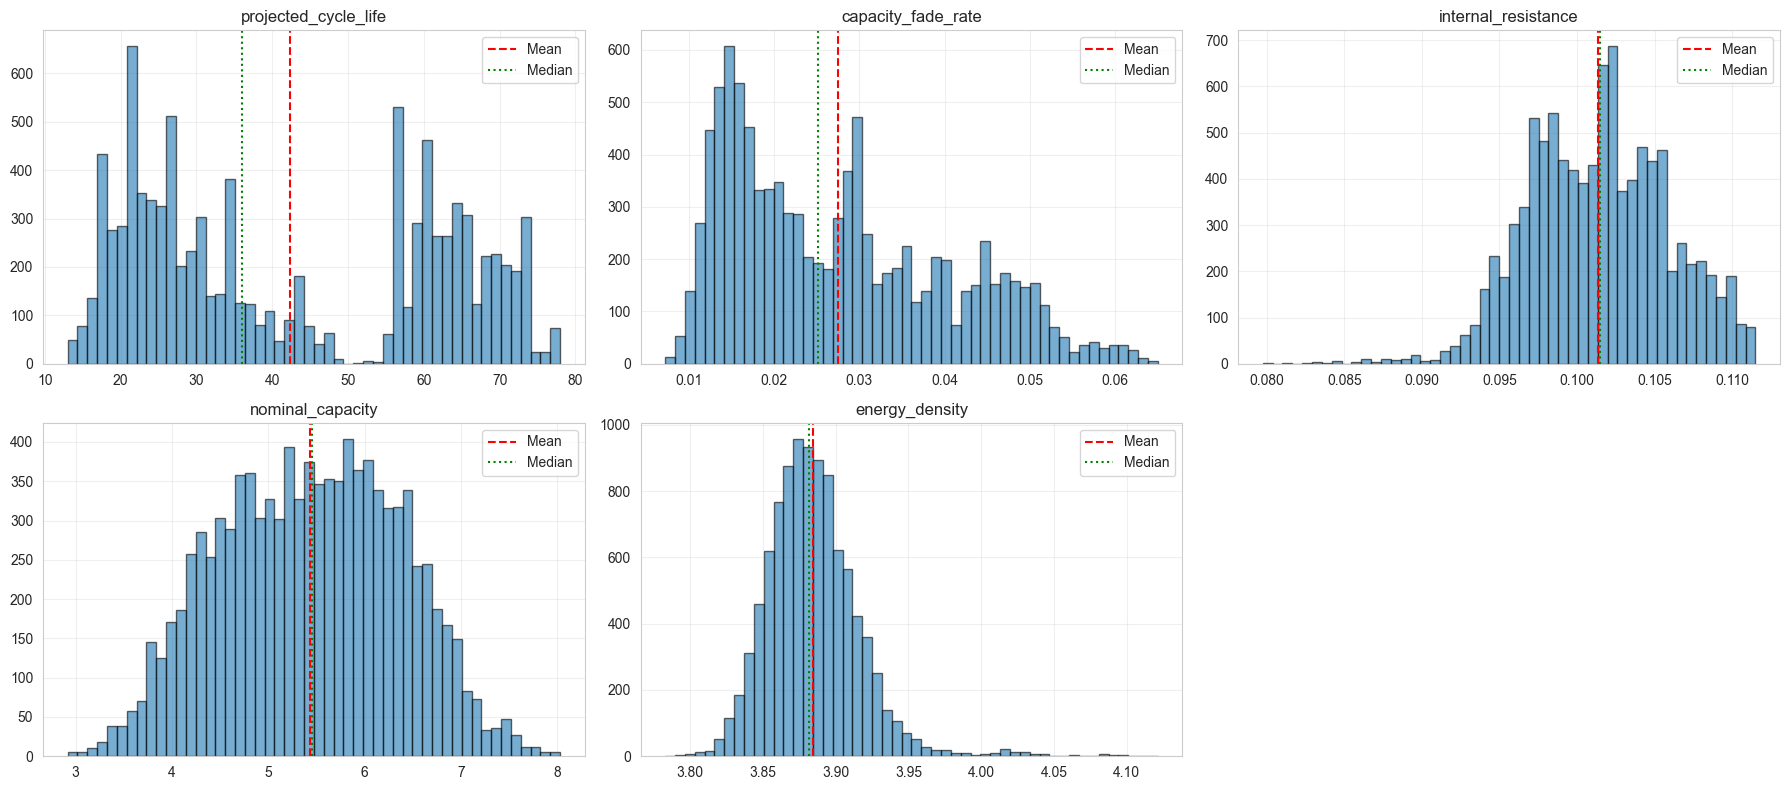

In [10]:
n_perf = len(PERFORMANCE_FEATURES)
n_cols = 3
n_rows = (n_perf + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for idx, feat in enumerate(PERFORMANCE_FEATURES):
    ax = axes[idx]
    data = df_perf[feat].dropna()
    if len(data) == 0:
        ax.set_title(f"{feat} (no data)")
        continue
    ax.hist(data, bins=50, alpha=0.6, edgecolor="black")
    ax.axvline(data.mean(), color="red", linestyle="--", label="Mean")
    ax.axvline(data.median(), color="green", linestyle=":", label="Median")
    ax.set_title(feat)
    ax.legend()
    ax.grid(True, alpha=0.3)

for idx in range(n_perf, len(axes)):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()


CORRELATION ANALYSIS

INPUT FEATURES → MICROSTRUCTURE OUTPUTS
--------------------------------------------------------------------------------

Top 10 Input → Microstructure Correlations:
   input_Separator porosity                           → porosity_measured        : -0.0000
   input_Positive electrode thickness [m]             → tau_factor               : -0.0000
   input_Lithium plating kinetic rate constant [m.s-1 → tau_factor               : +0.0000
   input_Lithium plating kinetic rate constant [m.s-1 → bruggeman_derived        : -0.0000
   input_Negative electrode cracking rate             → porosity_measured        : -0.0000
   input_Outer SEI partial molar volume [m3.mol-1]    → tau_factor               : +0.0000
   input_Negative electrode LAM constant proportional → porosity_measured        : -0.0000
   input_SEI kinetic rate constant [m.s-1]            → D_eff                    : +0.0000
   input_Positive particle radius [m]                 → bruggeman_derived        : 

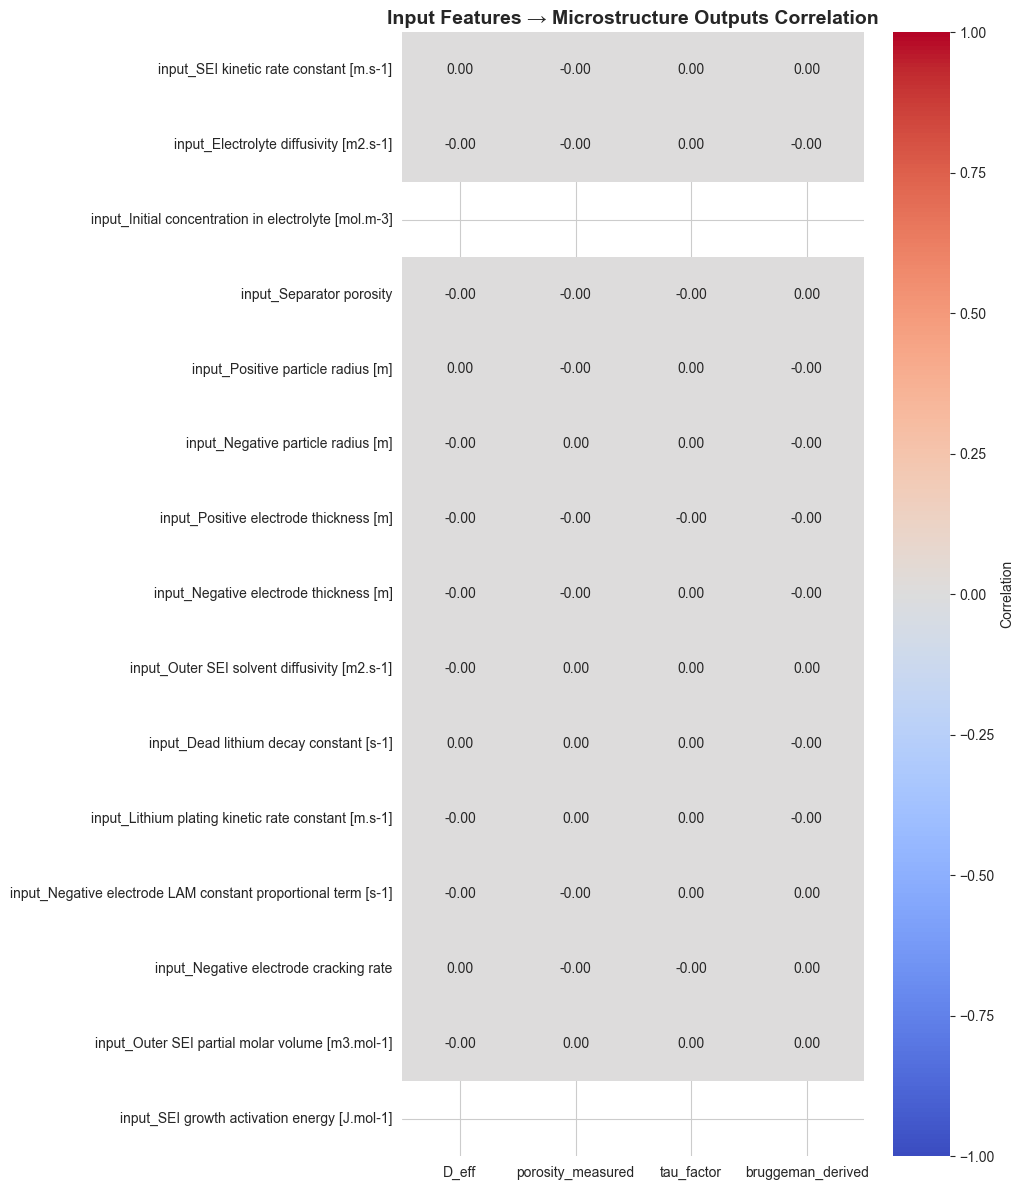


--------------------------------------------------------------------------------
INPUT FEATURES → PERFORMANCE OUTPUTS
--------------------------------------------------------------------------------

Top 10 Input → Performance Correlations:
   input_SEI kinetic rate constant [m.s-1]            → projected_cycle_life     : -0.8965
   input_SEI kinetic rate constant [m.s-1]            → capacity_fade_rate       : +0.8604
   input_Negative particle radius [m]                 → internal_resistance      : -0.8436
   input_Negative electrode thickness [m]             → internal_resistance      : +0.5375
   input_Negative particle radius [m]                 → energy_density           : +0.4086
   input_Negative particle radius [m]                 → capacity_fade_rate       : -0.4041
   input_Negative electrode thickness [m]             → capacity_fade_rate       : +0.3739
   input_Positive electrode thickness [m]             → nominal_capacity         : +0.3488
   input_Negative electrode th

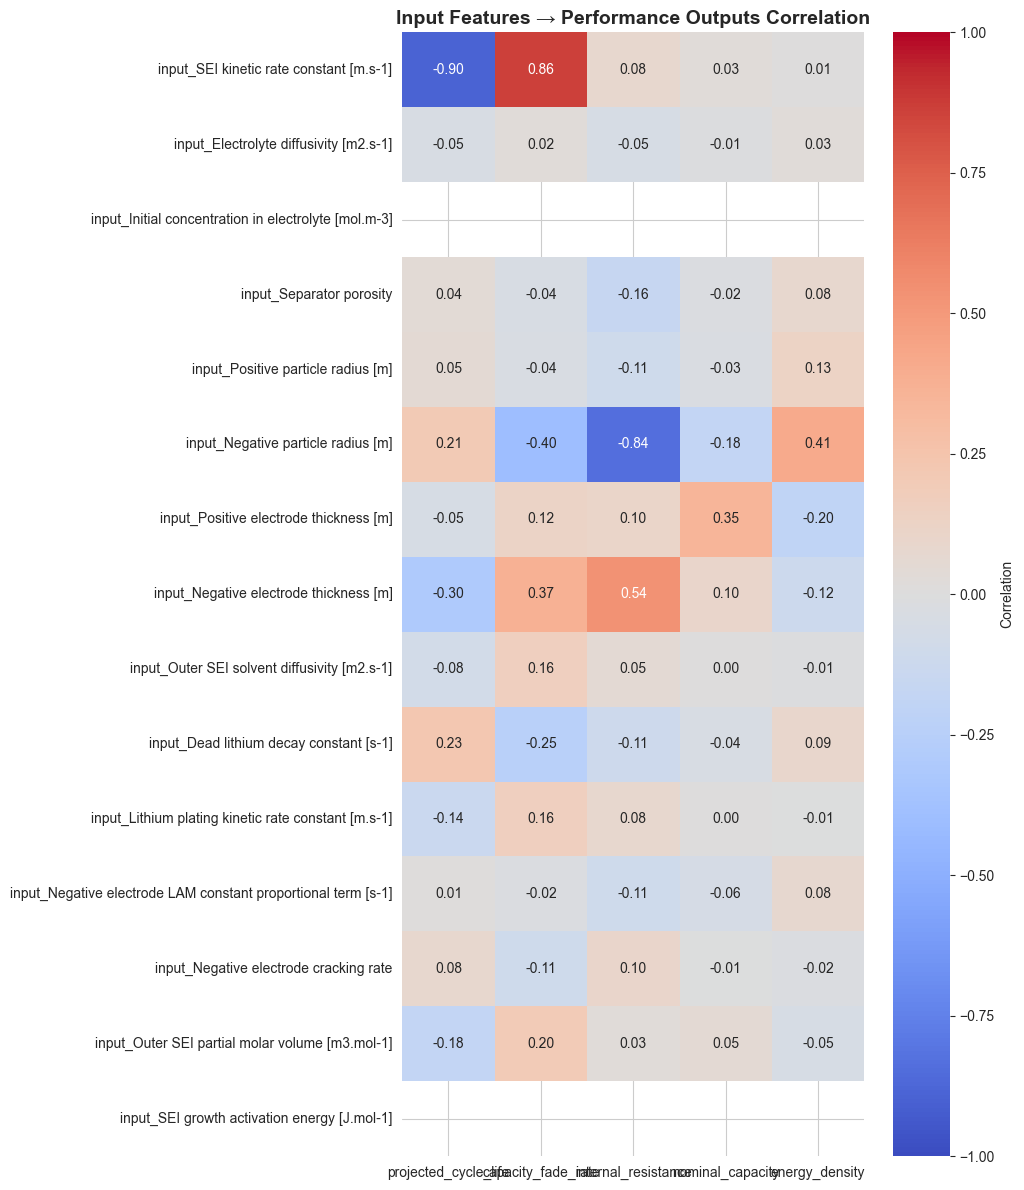


--------------------------------------------------------------------------------
MICROSTRUCTURE OUTPUTS → PERFORMANCE OUTPUTS
--------------------------------------------------------------------------------

Microstructure → Performance Correlation Matrix:
                   projected_cycle_life  capacity_fade_rate  internal_resistance  nominal_capacity  energy_density
D_eff                         -0.081651           -0.144244            -0.080269         -0.751649        0.357686
porosity_measured             -0.097638           -0.174314            -0.087067         -0.912481        0.444191
tau_factor                    -0.010753           -0.014916            -0.014060         -0.084915        0.064348
bruggeman_derived             -0.003626           -0.003095            -0.001694         -0.026426        0.034210


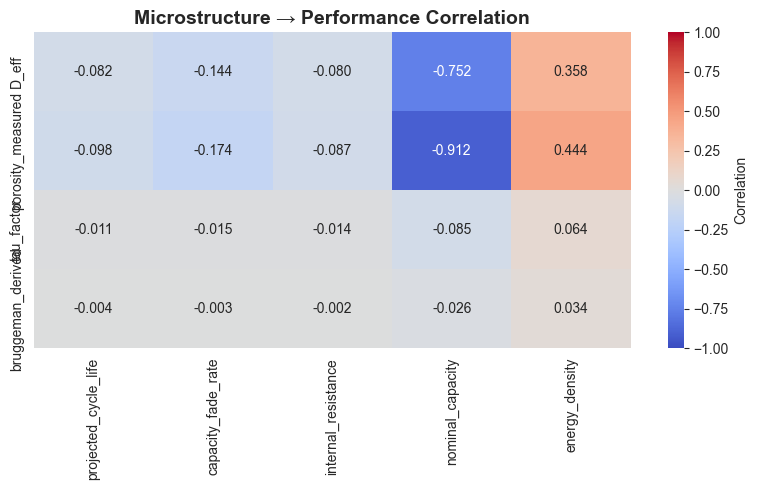

In [11]:
print(f"\n{'='*80}")
print(f"CORRELATION ANALYSIS")
print(f"{'='*80}\n")

# Input vs Microstructure Correlation
print("INPUT FEATURES → MICROSTRUCTURE OUTPUTS")
print("-" * 80)
corr_input_micro = pd.DataFrame(index=INPUT_FEATURES, columns=MICROSTRUCTURE_FEATURES)

for inp_feat in INPUT_FEATURES:
    for micro_feat in MICROSTRUCTURE_FEATURES:
        corr = df_inputs[inp_feat].corr(df_micro[micro_feat])
        corr_input_micro.loc[inp_feat, micro_feat] = corr

corr_input_micro = corr_input_micro.astype(float)

# Show top correlations
print("\nTop 10 Input → Microstructure Correlations:")
corr_flat = []
for inp in INPUT_FEATURES:
    for micro in MICROSTRUCTURE_FEATURES:
        val = abs(corr_input_micro.loc[inp, micro])
        if not np.isnan(val):
            corr_flat.append((inp, micro, corr_input_micro.loc[inp, micro]))

corr_flat_sorted = sorted(corr_flat, key=lambda x: abs(x[2]), reverse=True)
for inp, micro, val in corr_flat_sorted[:10]:
    print(f"   {inp[:50]:50s} → {micro:25s}: {val:+.4f}")

# Heatmap
fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(
    corr_input_micro,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    cbar_kws={"label": "Correlation"},
)
ax.set_title(
    "Input Features → Microstructure Outputs Correlation",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

# Input vs Performance Correlation
print(f"\n{'-'*80}")
print("INPUT FEATURES → PERFORMANCE OUTPUTS")
print("-" * 80)
corr_input_perf = pd.DataFrame(index=INPUT_FEATURES, columns=PERFORMANCE_FEATURES)

for inp_feat in INPUT_FEATURES:
    for perf_feat in PERFORMANCE_FEATURES:
        corr = df_inputs[inp_feat].corr(df_perf[perf_feat])
        corr_input_perf.loc[inp_feat, perf_feat] = corr

corr_input_perf = corr_input_perf.astype(float)

# Show top correlations
print("\nTop 10 Input → Performance Correlations:")
corr_flat = []
for inp in INPUT_FEATURES:
    for perf in PERFORMANCE_FEATURES:
        val = abs(corr_input_perf.loc[inp, perf])
        if not np.isnan(val):
            corr_flat.append((inp, perf, corr_input_perf.loc[inp, perf]))

corr_flat_sorted = sorted(corr_flat, key=lambda x: abs(x[2]), reverse=True)
for inp, perf, val in corr_flat_sorted[:10]:
    print(f"   {inp[:50]:50s} → {perf:25s}: {val:+.4f}")

# Heatmap
fig, ax = plt.subplots(figsize=(10, 12))
sns.heatmap(
    corr_input_perf,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    cbar_kws={"label": "Correlation"},
)
ax.set_title(
    "Input Features → Performance Outputs Correlation", fontsize=14, fontweight="bold"
)
plt.tight_layout()
plt.show()

# Microstructure vs Performance Correlation
print(f"\n{'-'*80}")
print("MICROSTRUCTURE OUTPUTS → PERFORMANCE OUTPUTS")
print("-" * 80)
corr_micro_perf = pd.DataFrame(
    index=MICROSTRUCTURE_FEATURES, columns=PERFORMANCE_FEATURES
)

for micro_feat in MICROSTRUCTURE_FEATURES:
    for perf_feat in PERFORMANCE_FEATURES:
        corr = df_micro[micro_feat].corr(df_perf[perf_feat])
        corr_micro_perf.loc[micro_feat, perf_feat] = corr

corr_micro_perf = corr_micro_perf.astype(float)

print("\nMicrostructure → Performance Correlation Matrix:")
print(corr_micro_perf.to_string())

# Heatmap
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(
    corr_micro_perf,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    cbar_kws={"label": "Correlation"},
)
ax.set_title("Microstructure → Performance Correlation", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [12]:
print(f"\n{'='*80}")
print(f"FEATURE USEFULNESS ASSESSMENT")
print(f"{'='*80}\n")

# Check which inputs have meaningful correlation with ANY output
print("INPUT FEATURE USEFULNESS")
print("-" * 80)

input_max_corr = {}
for inp_feat in INPUT_FEATURES:
    # Max absolute correlation with microstructure
    micro_corrs = [
        abs(corr_input_micro.loc[inp_feat, m]) for m in MICROSTRUCTURE_FEATURES
    ]
    max_micro = max([c for c in micro_corrs if not np.isnan(c)] or [0])

    # Max absolute correlation with performance
    perf_corrs = [abs(corr_input_perf.loc[inp_feat, p]) for p in PERFORMANCE_FEATURES]
    max_perf = max([c for c in perf_corrs if not np.isnan(c)] or [0])

    max_overall = max(max_micro, max_perf)
    input_max_corr[inp_feat] = max_overall

# Sort by max correlation
input_usefulness = sorted(input_max_corr.items(), key=lambda x: x[1], reverse=True)

print("\nInput Features Ranked by Max Correlation with Outputs:")
print(f"{'Feature':<60s} | Max |Corr|")
print("-" * 80)
for feat, corr in input_usefulness:
    usefulness = (
        "✓✓✓" if corr > 0.5 else "✓✓" if corr > 0.3 else "✓" if corr > 0.1 else "⚠️"
    )
    print(f"{feat:<60s} | {corr:.4f} | {usefulness}")

# Identify potentially redundant features
print(f"\n{'-'*80}")
print("POTENTIALLY WEAK FEATURES (|corr| < 0.1 with all outputs):")
print("-" * 80)
weak_features = [feat for feat, corr in input_usefulness if corr < 0.1]
if weak_features:
    for feat in weak_features:
        print(f"   • {feat}")
else:
    print("   None - all features show some correlation!")

# Check output feature variance
print(f"\n{'-'*80}")
print("OUTPUT FEATURE QUALITY")
print("-" * 80)
print("\nMicrostructure outputs:")
for feat in MICROSTRUCTURE_FEATURES:
    std = df_micro[feat].std()
    nan_pct = df_micro[feat].isnull().sum() / len(df_micro) * 100
    status = "✓" if std > 0 and nan_pct < 10 else "⚠️"
    print(f"   {status} {feat:30s}: std={std:.6f}, missing={nan_pct:.1f}%")

print("\nPerformance outputs:")
for feat in PERFORMANCE_FEATURES:
    std = df_perf[feat].std()
    nan_pct = df_perf[feat].isnull().sum() / len(df_perf) * 100
    status = "✓" if std > 0 and nan_pct < 10 else "⚠️"
    print(f"   {status} {feat:30s}: std={std:.6f}, missing={nan_pct:.1f}%")


FEATURE USEFULNESS ASSESSMENT

INPUT FEATURE USEFULNESS
--------------------------------------------------------------------------------

Input Features Ranked by Max Correlation with Outputs:
Feature                                                      | Max |Corr|
--------------------------------------------------------------------------------
input_SEI kinetic rate constant [m.s-1]                      | 0.8965 | ✓✓✓
input_Negative particle radius [m]                           | 0.8436 | ✓✓✓
input_Negative electrode thickness [m]                       | 0.5375 | ✓✓✓
input_Positive electrode thickness [m]                       | 0.3488 | ✓✓
input_Dead lithium decay constant [s-1]                      | 0.2489 | ✓
input_Outer SEI partial molar volume [m3.mol-1]              | 0.1987 | ✓
input_Lithium plating kinetic rate constant [m.s-1]          | 0.1600 | ✓
input_Outer SEI solvent diffusivity [m2.s-1]                 | 0.1580 | ✓
input_Separator porosity                            

In [13]:
print(f"\n{'='*80}")
print(f"EXPORTING ANALYSIS RESULTS")
print(f"{'='*80}\n")

summary = {
    "dataset": {
        "total_rows": len(df_expanded),
        "unique_samples": int(df_expanded["sample_id"].nunique()),
        "unique_params": int(df_expanded["param_id"].nunique()),
    },
    "features": {
        "input_features": len(INPUT_FEATURES),
        "microstructure_features": len(MICROSTRUCTURE_FEATURES),
        "performance_features": len(PERFORMANCE_FEATURES),
    },
    "data_quality": {
        "missing_data_pct": float(
            df_expanded.isnull().sum().sum()
            / (df_expanded.shape[0] * df_expanded.shape[1])
            * 100
        ),
        "complete_rows": int(df_expanded.dropna().shape[0]),
        "complete_rows_pct": float(
            df_expanded.dropna().shape[0] / len(df_expanded) * 100
        ),
    },
    "top_input_microstructure_correlations": [
        {"input": inp, "microstructure": micro, "correlation": float(val)}
        for inp, micro, val in corr_flat_sorted[:5]
    ],
}

summary_file = BASE_DIR / "data" / "intermediate_analysis_summary.json"
with open(summary_file, "w") as f:
    json.dump(summary, f, indent=2)

sample_file = BASE_DIR / "data" / "intermediate_sample.csv"
df_expanded.head(100).to_csv(sample_file, index=False)

print(f"✓ Summary saved to: {summary_file}")
print(f"✓ Sample data saved to: {sample_file}")
print(f"\n{'='*80}")
print("ANALYSIS COMPLETE!")
print(f"{'='*80}")


EXPORTING ANALYSIS RESULTS

✓ Summary saved to: ../data/intermediate_analysis_summary.json
✓ Sample data saved to: ../data/intermediate_sample.csv

ANALYSIS COMPLETE!
